<a href="https://colab.research.google.com/github/CoDeRror555/Analytic_projects/blob/main/predict_fitness_churn/predict_fitness_churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Регрессионный анализ оттока клиентов фитнес клуба, их кластеризация на основе анкетных данных.

# Основные цели:
* **Научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента**
* **сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства**
* **Проанализировать основные признаки, наиболее сильно влияющие на отток**
 ## Решённые задачи:
 - [x] **Проведена предобработка данных**
 - [x] **Выявлены особенности пользователей по их анкетам данным**
 - [x] **Определены отличительные особенности тех кто попал в отток и нет**
 - [x] **Убраны подобные, коррелирующие признаки и добавлены новые для построения лучшей модели**
 - [x] **Построена регрессионная логистическая модель и модель методом случайного леса предсказывающие факт оттока клиента**
 - [x] **Проведен анализ работы модели и определены уровни значимости предикторов**
 - [x] **Проведена кластеризация пользователей методом Kmeans**
 - [x] **Определенны отличительные особенности кластеров**
 - [x] **Даны рекомендации по взаимодействию с клиентами и их удержанию**
### Используемые инструменты:
   * *python, numpy, pandas, matplotlib, seaborn, sklearn*
* **

In [ ]:
# запросы в интернет
import urllib
import requests

# работа с таблицами
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# кластеризация
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

# regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,  roc_auc_score

# warnings ignored
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [ ]:
# загрузим данные
# global case case
df = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/BTTyEj62ZWXfNg',index_col=0)

In [ ]:
# функция для получения иныфо о данных
def df_info(df:pd.DataFrame) -> None:
    '''Распечатывает информацию о датафрейме'''
    print(f"Количество полных дубликатов: {df.duplicated().sum()}")
    print('****************')

    # Выводим инфо
    df.info()


    # Сохраняем пропуски
    df_nans = np.trim_zeros(df.isna().mean().sort_values())

    if len(df_nans > 0):
        print('\nNA:',end='')
        display(df_nans)

    # Пример данных
    display(df.dropna().sample().T)

    for col in df.columns:
        if df[col].nunique() < 20:
            display(df[col].value_counts())

In [ ]:
# добавляет аннотации к барам
def add_value_labels(ax,bar_or_barh, space=4,fmt="{:.1f}"):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
        frm: format annotaitions
        bar_or_barh: chose bar or barh pyplot
    """
    if bar_or_barh == 'bar':
        # For each bar: Place a label
        heights = [rect.get_height() for rect in ax.patches]
        for rect in ax.patches:
            # Get X and Y placement of label from rect.
            y_value = rect.get_height()
            x_value = rect.get_x() + rect.get_width() / 2


            if y_value > 0:
                va = 'bottom'
                label = fmt.format(y_value)
                # Create annotation
                if y_value > max(heights)/2:
                    ax.annotate(
                        label,                      # Use `label` as label
                        (x_value, y_value/2),         # Place label at end of the bar
                        xytext=(0, space),          # Vertically shift label by `space`
                        textcoords="offset points", # Interpret `xytext` as offset in points
                        ha='center',                # Horizontally center label
                        va=va,
                        rotation=90,color='black',bbox = dict(boxstyle="round", fc="w", ec="0.99", alpha=0.7),size = 10)                      # Vertically align label differently for
                else:
                    ax.annotate(
                        label,                      # Use `label` as label
                        (x_value, rect.get_y()+rect.get_height()),         # Place label at end of the bar
                        xytext=(0, space),          # Vertically shift label by `space`
                        textcoords="offset points", # Interpret `xytext` as offset in points
                        ha='center',                # Horizontally center label
                        va=va,
                        rotation=90,size = 10)
            elif y_value == 0:
                va = 'top'
                label = fmt.format(y_value)
                ax.annotate(
                        label,                      # Use `label` as label
                        (x_value, rect.get_y()+rect.get_height()),         # Place label at end of the bar
                        xytext=(0, space),          # Vertically shift label by `space`
                        textcoords="offset points", # Interpret `xytext` as offset in points
                        ha='center',                # Horizontally center label
                        va='center',
                        rotation=90,size = 10)

            else:

                # Invert space to place label belo
                # Vertically align label at top
                va = 'top'
                # Use Y value as label and format number with one decimal place
                label = fmt.format(y_value)
                    # Create annotation
                if y_value < min(heights)/2:
                    ax.annotate(
                        label,                      # Use `label` as label
                        (x_value, y_value/2),         # Place label at end of the bar
                        xytext=(0, 0),          # Vertically shift label by `space`
                        textcoords="offset points", # Interpret `xytext` as offset in points
                        ha='center',                # Horizontally center label
                        va=va,
                        rotation=90,color='black',bbox = dict(boxstyle="round", fc="w", ec="0.99", alpha=0.7),size = 10)                      # Vertically align label differently for
                                                    # positive and negative values.
                else:
                    ax.annotate(
                        label,                      # Use `label` as label
                        (x_value, rect.get_y()+rect.get_height()),         # Place label at end of the bar
                        xytext=(0, 0),          # Vertically shift label by `space`
                        textcoords="offset points", # Interpret `xytext` as offset in points
                        ha='center',                # Horizontally center label
                        va=va,
                        rotation=90,size = 10)                      # Vertically align label differently for
                                                # positive and negative values.
    elif bar_or_barh == 'barh':

        # Получаем ширины столбиков
        widths = [rect.get_width() for rect in ax.patches]
        heights = [rect.get_height() for rect in ax.patches]
        # Добавляем аннотации на каждый столбик
        for i, rect in enumerate(ax.patches):
            # Перемещаем аннотацию внутрь столбика
            if widths[i] < 0:
                if widths[i] < min(widths)/2:
                    space *= -1
                    ax.annotate(fmt.format(widths[i]), xy=(widths[i]/2, rect.get_y() + rect.get_height()/2),\
                                xytext=(0, 0), textcoords="offset points", ha='center', va='center',color='black',bbox = dict(boxstyle="round", fc="w", ec="0.99", alpha=0.7),size = 10)
                else:
                    space *= -1
                    ax.annotate(fmt.format(widths[i]), xy=(rect.get_x() + rect.get_width(),rect.get_y() + rect.get_height() / 2),\
                            xytext=(space-3, 0), textcoords="offset points", ha='right', va='center',size = 10)

            elif widths[i] == 0:
                ax.annotate(fmt.format(widths[i]), xy=(widths[i],rect.get_y() + rect.get_height()/2),\
                            xytext=(0, 0), textcoords="offset points", ha='center', va='center',size = 10)

            elif widths[i] > 0:
                if widths[i] > max(widths)/2:
                    ax.annotate(fmt.format(widths[i]), xy=(widths[i]/2, rect.get_y() + rect.get_height()/2),\
                                xytext=(0, 0), textcoords="offset points", ha='center', va='center',color='black',bbox = dict(boxstyle="round", fc="w", ec="0.99", alpha=0.7),size = 10)

                else:
                    ax.annotate(fmt.format(widths[i]), xy=(rect.get_x() + rect.get_width(),rect.get_y() + rect.get_height() / 2),\
                            xytext=(space, 0), textcoords="offset points", ha='left', va='center',size = 10)
    else:
        return(print("inter name 'bar or bash'"))

# Предобработка и исследовательский анализ данных

## Предобработка

In [ ]:
# посмотрим на шапку датасета
display(df.head())

,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
gender,,,,,,,,,,,,,
1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [ ]:
# поднимем пол из индекса
df = df.reset_index()

In [ ]:
# выведем основную информацию о датасете
df_info(df)

Количество полных дубликатов: 0
****************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_cla

,2131
gender,1.000000
Near_Location,1.000000
Partner,1.000000
Promo_friends,0.000000
Phone,0.000000
Contract_period,1.000000
Group_visits,0.000000
Age,30.000000
Avg_additional_charges_total,105.189793
Month_to_end_contract,1.000000


1    2041
0    1959
Name: gender, dtype: int64

1    3381
0     619
Name: Near_Location, dtype: int64

0    2053
1    1947
Name: Partner, dtype: int64

0    2766
1    1234
Name: Promo_friends, dtype: int64

1    3614
0     386
Name: Phone, dtype: int64

1     2207
12     960
6      833
Name: Contract_period, dtype: int64

0    2351
1    1649
Name: Group_visits, dtype: int64

1.0     2207
6.0      645
12.0     524
11.0     181
5.0      130
10.0      82
9.0       73
4.0       58
8.0       38
7.0       25
3.0       23
2.0       14
Name: Month_to_end_contract, dtype: int64

0    2939
1    1061
Name: Churn, dtype: int64

* **После анализа основной информации мы можем заметить наличие номинативных и количественных переменных. Пропорции некоторых номинативных переменных имеют большую диспропорцию, в том числе и целевой параметр оттока. Пропусков и дубликатов нет**

In [ ]:
# посмотрим на описательную татистику переменных
display(df.describe(include=float))
display(df.describe(exclude=float))

,Avg_additional_charges_total,Month_to_end_contract,Avg_class_frequency_total,Avg_class_frequency_current_month
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,146.943728,4.322750,1.879020,1.767052
std,96.355602,4.191297,0.972245,1.052906
min,0.148205,1.000000,0.000000,0.000000
25%,68.868830,1.000000,1.180875,0.963003
50%,136.220159,1.000000,1.832768,1.719574
75%,210.949625,6.000000,2.536078,2.510336
max,552.590740,12.000000,6.023668,6.146783


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Lifetime,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,3.724750,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,3.749267,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,1.000000,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,3.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,5.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,31.000000,1.000000


* **Стандартное отклонение некоторых признаков имеет довольно высокие значения, что может говорить о ненормальности распределения и необходимости стандартизации данных при построении моделей**

## Анализ распределения признаков в целевых группах

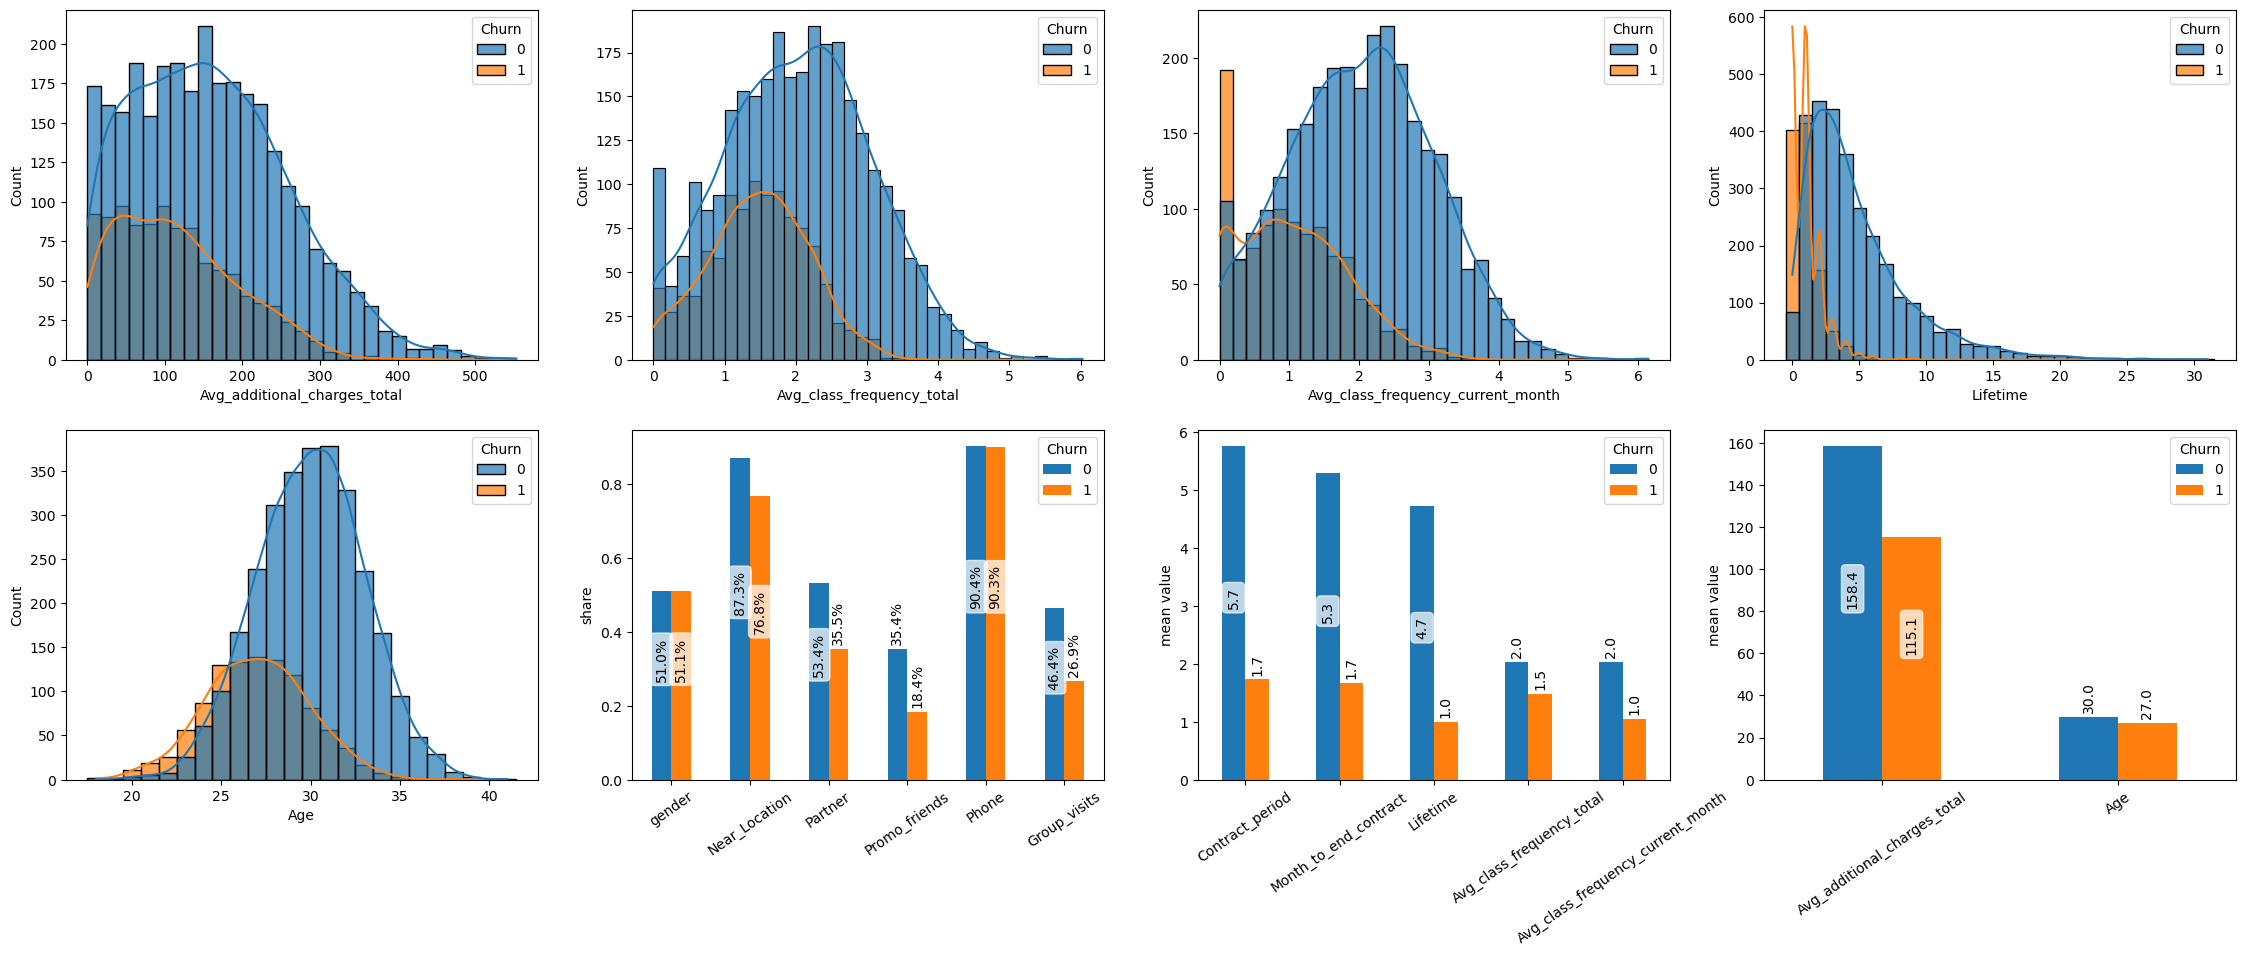

In [ ]:
plt.figure(figsize=(28, 10))

# Plotting share of nominative predictors and mean values of it
ax1 = plt.subplot(2, 4, 6)
df.groupby(by='Churn')[['gender','Near_Location',   'Partner',  'Promo_friends',    'Phone',    'Group_visits']].mean().T.plot(kind='bar',ax = ax1)
plt.xticks(rotation=(35))
plt.ylabel('share')
add_value_labels(ax1,'bar',3,"{:.1%}")
ax2 = plt.subplot(2, 4, 7)
df.groupby(by='Churn')[['Contract_period',  'Month_to_end_contract',    'Lifetime', 'Avg_class_frequency_total','Avg_class_frequency_current_month']].mean().T.plot(kind='bar',ax = ax2)
plt.xticks(rotation=(35))
plt.ylabel('mean value')
add_value_labels(ax2,'bar',3)
ax3 = plt.subplot(2, 4, 8)
df.groupby(by='Churn')[['Avg_additional_charges_total', 'Age']].mean().T.plot(kind='bar',ax = ax3)
plt.xticks(rotation=(35))
plt.ylabel('mean value')
add_value_labels(ax3,'bar',3)


# Plotting histograms of float predictors
ax4 = plt.subplot(2, 4, 1)
sns.histplot(data=df, x="Avg_additional_charges_total", hue="Churn", color=['r','b'], alpha = 0.7, kde = True, ax= ax4)
ax5 = plt.subplot(2, 4, 2)
sns.histplot(data=df, x="Avg_class_frequency_total", hue="Churn", color=['r','b'], alpha = 0.7, kde = True, ax= ax5)
ax6 = plt.subplot(2, 4, 3)
sns.histplot(data=df, x="Avg_class_frequency_current_month", hue="Churn", color=['r','b'], alpha = 0.7, kde = True, ax= ax6)


# Plotting histograms of discrete predictors
ax7 = plt.subplot(2, 4, 4)
sns.histplot(data=df, x="Lifetime", hue="Churn",discrete=True, color=['r','b'], alpha = 0.7, kde = True, ax= ax7)
ax8 = plt.subplot(2, 4, 5)
sns.histplot(data=df, x="Age", hue="Churn",discrete=True, color=['r','b'], alpha = 0.7, kde = True, ax= ax8)


plt.show()

* **На графиках мы можем заметить некоторые особенности в распределении признаков в группах оттока и нет. Так признаки пола и наличие телефона имеют одинаковую долю в обеих группах, тогда как все остальные номинативные признаки в группе оттока имеют понеженное ее значение. Средние показатели количественных и дискретных значений также имеют пониженное значение в группе оттока с разной степенью выраженности. Распределения количественных и дискретных величин имеет явное смещение в группе оттока в меньшую сторону, так же на гистограммах срока жизни и среднего количества посещений за текущий месяц видны ярко выраженные всплески количества околунулевых значений.**

## Анализ матрицы корреляции признаков

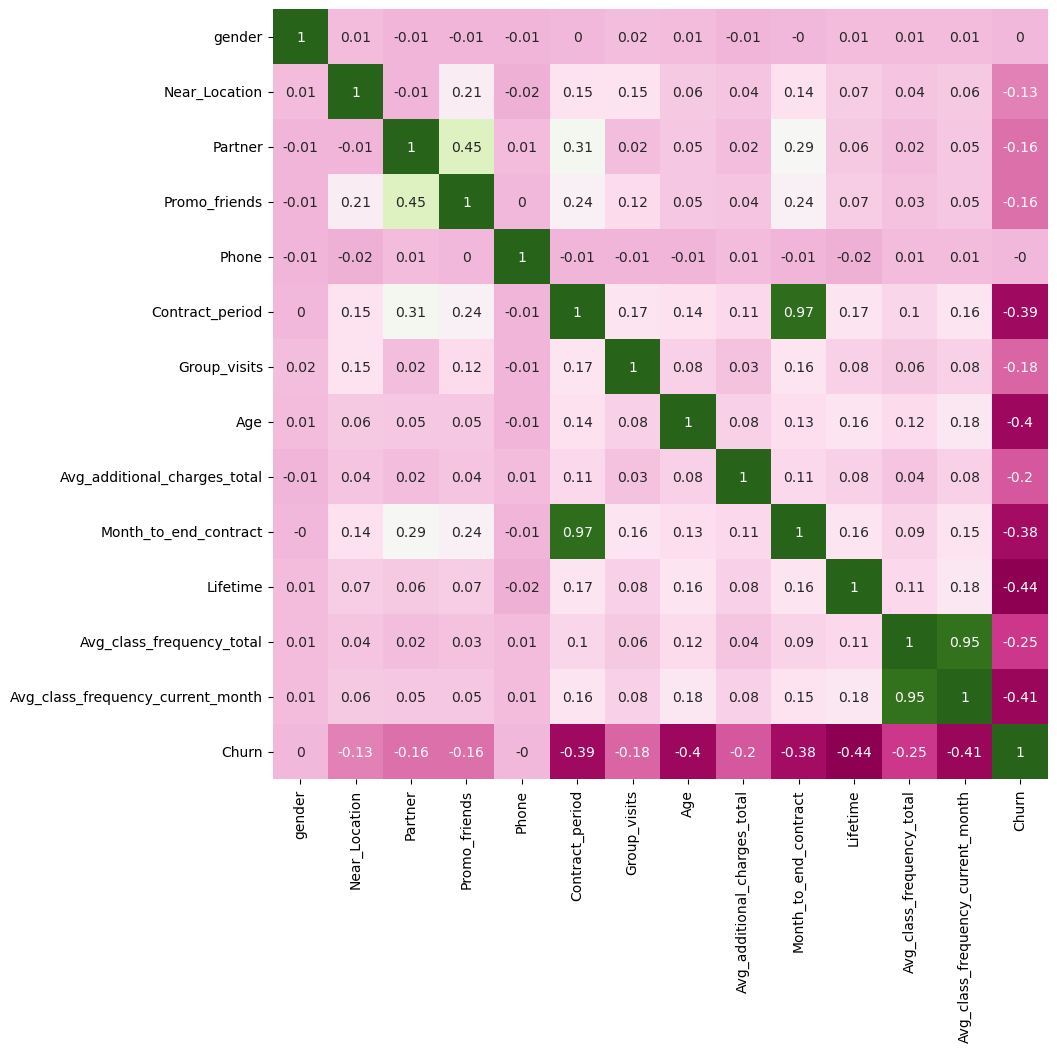

In [ ]:
# построим матрицу корреляций
plt.figure(figsize=(10,10))
sns.heatmap(round(df.corr(),2), annot=True,cbar=False,cmap="PiYG")
plt.show()

* **На графике можно заметить отрицательную связь всех предикторов с целевой переменной, что в принципе можно было заметить на графиках выше. Также видно 4 попарно коррелирующих признака с критическим уровнем связи, судя по наименованию логическая связь тоже присутствует значит они отображают очень похожие признаки. Для построения более качественной предсказательной модели во избежание пагубных последствий мультиколлинеарности переработаем эти признаки и постараемся избавиться от столь сильной зависимости**

* **Сформируем новые признаки на основе попарно скоррелированных, чтобы не терять их описательную силу. Один из старых уберем**

In [ ]:
# признак описывает разность между периодом контракта и остатком до конца контракта, совего рода life time в пределах контрактного периода
df['new_period_metric'] = df.Contract_period - df.Month_to_end_contract

In [ ]:
# признак описывает разницу между общей средней частотой посещения и средней частотой за последний месяц
df['new_frequency_metric'] = df.Avg_class_frequency_total - df.Avg_class_frequency_current_month

In [ ]:
# уберем по одному старому признаку и построим матрицу повторно
df = df.drop(['Contract_period', 'Avg_class_frequency_current_month'], axis = 1)

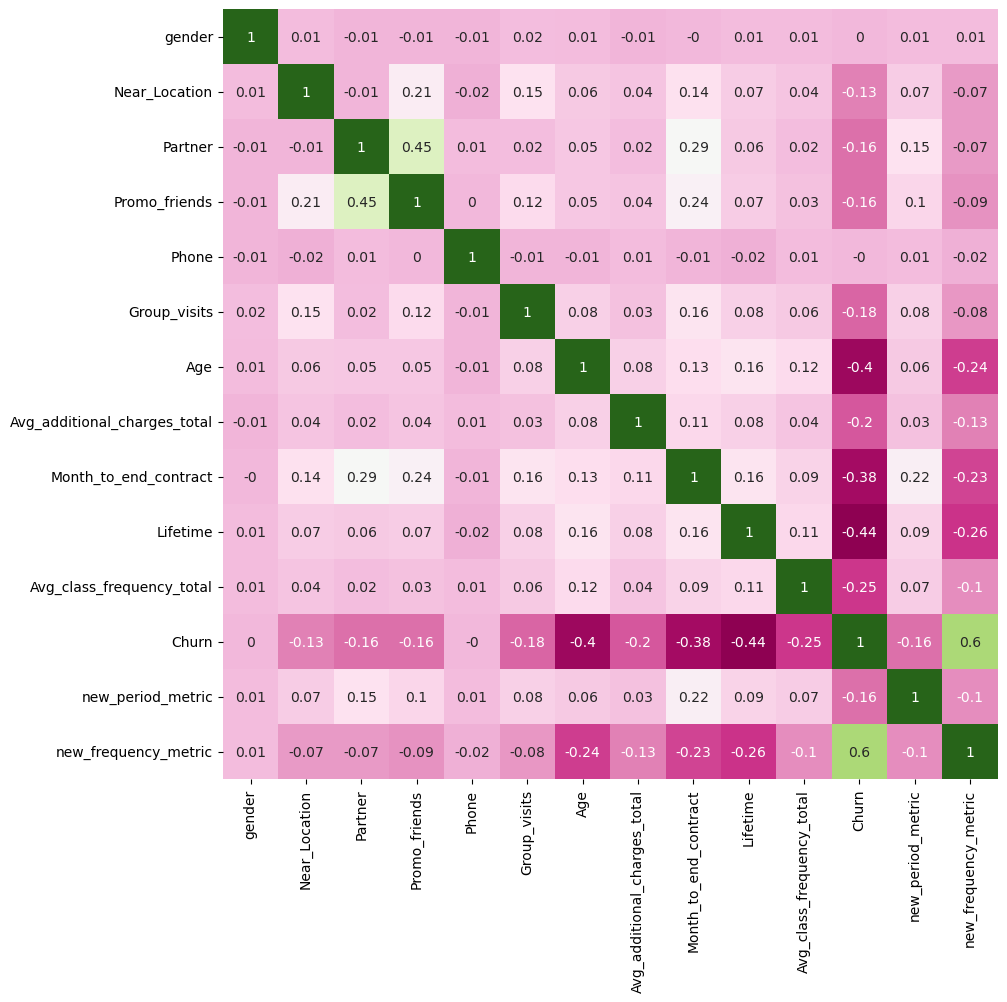

In [ ]:
# построим матрицу корреляций
plt.figure(figsize=(10,10))
sns.heatmap(round(df.corr(),2), annot=True,cbar=False,cmap="PiYG")
plt.show()

* **Мы избавились от внутренней экстремальной корреляции признаков и получили два новых, один из которых имеет довольно высокую положительную связь с целевой переменной, что может усилить предсказательную способность нашей будущей модели. Так же эти признаки легко интерпретировать**

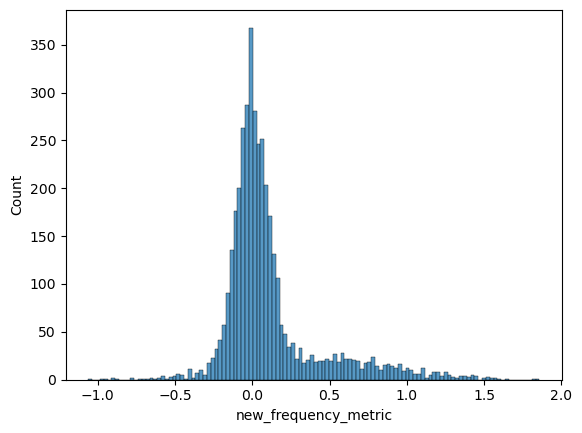

count    4000.000000
mean        0.111968
std         0.321350
min        -1.060218
25%        -0.056744
50%         0.022433
75%         0.141110
max         1.856764
Name: new_frequency_metric, dtype: float64

In [ ]:
# посмотрим на распределение значений нового признакпи
sns.histplot(df.new_frequency_metric)
plt.show()
display(df.new_frequency_metric.describe())

* **Новая метрика имеет близкое к нормальному распределение и низкое значение стандартного отклонения, что может быть полезно при построении модели**

# Вывод после EDA:

# Построение прогностической модели способами логистической регрессии и случайного леса

In [ ]:
# определим функцию, которая будет выводить наши метрики
def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))


# посмотрим, как соотносятся классы для нашего набора данных
print(df['Churn'].value_counts())

# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = df.drop('Churn', axis=1)
y = df['Churn']

# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0, stratify = y
)

# обучим StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)

# Преобразем обучающий и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

# зададим алгоритм для модели логистической регрессии
lr_model = LogisticRegression(random_state=0)
# обучим модель
lr_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:, 1]
# выведем все метрики
print_all_metrics(
    y_test,
    lr_predictions,
    lr_probabilities,
    title='Метрики для модели логистической регрессии:',
)

# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0) # Ваш код здесь
# обучим модель случайного леса
rf_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test_st)# Ваш код здесь
rf_probabilities = rf_model.predict_proba(X_test_st)[:, 1]# Ваш код здесь
# выведем все метрики
print_all_metrics(
    y_test,
    rf_predictions,
    rf_probabilities,
    title='Метрики для модели случайного леса:'
)

0    2939
1    1061
Name: Churn, dtype: int64
Метрики для модели логистической регрессии:
	Accuracy: 0.93
	Precision: 0.90
	Recall: 0.84
	F1: 0.87
	ROC_AUC: 0.97
Метрики для модели случайного леса:
	Accuracy: 0.96
	Precision: 0.96
	Recall: 0.87
	F1: 0.91
	ROC_AUC: 0.99


* **Получились довольно высокие показатели в обеих моделях, однако модель случайного леса все же точнее и имеет выше баланс точности F1. Однако выборка не совсем сбалансирована и пользователей в оттоке и 3 раза меньше, поэтому некоторые метрики могут быть не совсем достоверными особенно доля правильных ответов из всех.**

* **Проведем анализ влияния предикторов при прогнозировании в наших моделях**

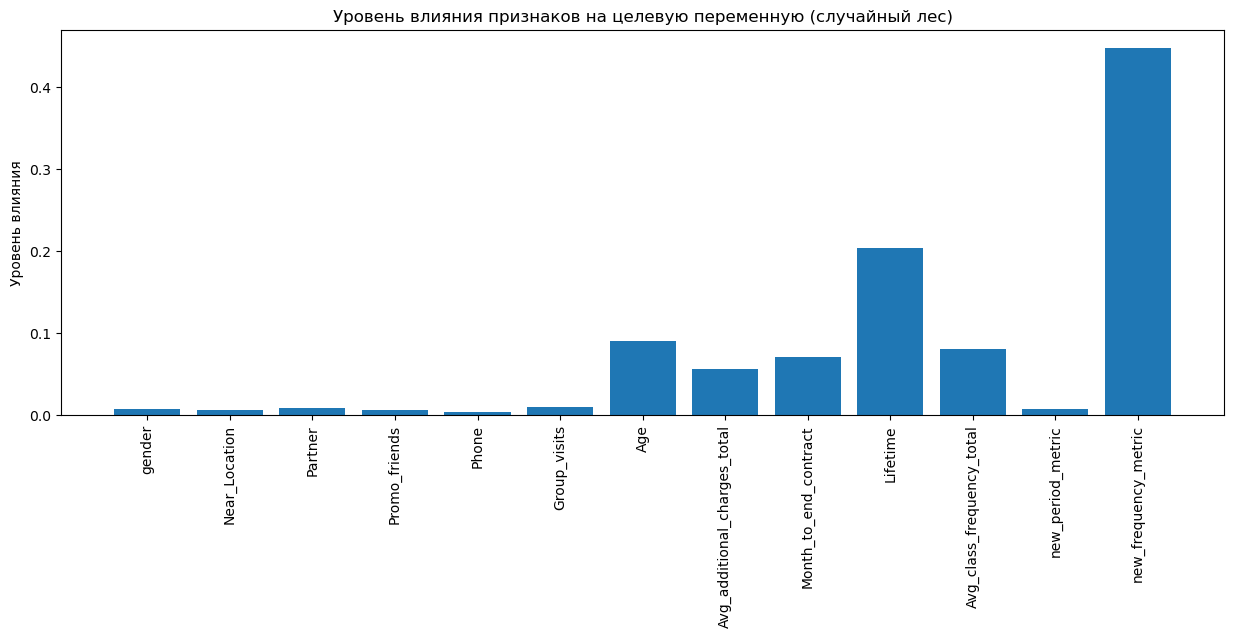

In [ ]:
# построим график
plt.figure(figsize=(15,5))
plt.bar(x=X.columns, height=rf_model.feature_importances_)
plt.title("Уровень влияния признаков на целевую переменную (случайный лес)")
plt.xticks(rotation = (90))
plt.ylabel('Уровень влияния')


plt.show()

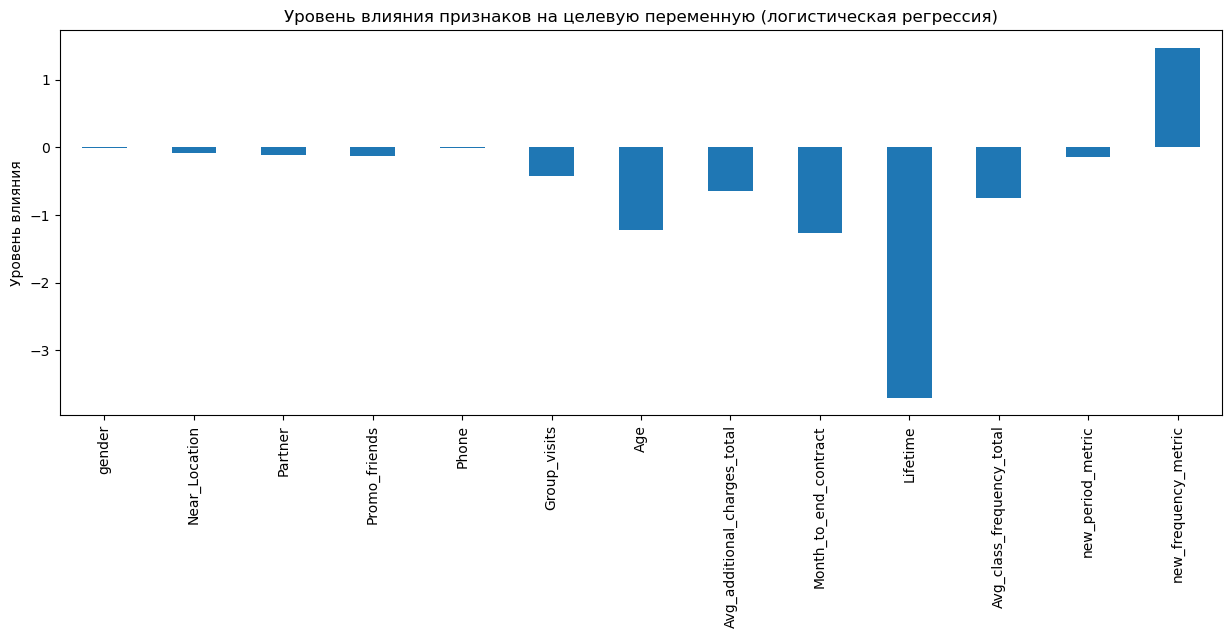

In [ ]:
# построим график
coef = pd.DataFrame(lr_model.coef_)
coef.columns = X.columns
coef.T.plot(kind='bar',figsize=(15,5), legend = False)
plt.title("Уровень влияния признаков на целевую переменную (логистическая регрессия)")
plt.xticks(rotation = (90))
plt.ylabel('Уровень влияния')
plt.show()

* **Мы видим, что максимальный вклад в прогностическую способность наших моделей вкладывают lifetime, age, month_to_end_contract и наша новая частотная метрика, причем степень их влияния в каждой модели разная. Также можно заметить, что некоторые предикторы оказывают минимальное воздействие на предсказательную способность наших моделей, есть смысл попробовать их убрать и построить модели по упрощенной матрице**

In [ ]:
# оставим предикторы с высоким уровнем влияния
df_clean = df[['Promo_friends', 'Group_visits', 'Age',  'Avg_additional_charges_total', 'Month_to_end_contract',    'Lifetime', 'Avg_class_frequency_total',    'new_period_metric',    'new_frequency_metric','Churn']]

In [ ]:
# определим функцию, которая будет выводить наши метрики
def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))


# посмотрим, как соотносятся классы для нашего набора данных
print(df_clean['Churn'].value_counts())

# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = df_clean.drop('Churn', axis=1)
y = df_clean['Churn']

# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0, stratify = y
)

# обучим StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)

# Преобразем обучающий и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

# зададим алгоритм для модели логистической регрессии
lr_model = LogisticRegression(random_state=0)
# обучим модель
lr_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:, 1]
# выведем все метрики
print_all_metrics(
    y_test,
    lr_predictions,
    lr_probabilities,
    title='Метрики для модели логистической регрессии:',
)

# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0) # Ваш код здесь
# обучим модель случайного леса
rf_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test_st)# Ваш код здесь
rf_probabilities = rf_model.predict_proba(X_test_st)[:, 1]# Ваш код здесь
# выведем все метрики
print_all_metrics(
    y_test,
    rf_predictions,
    rf_probabilities,
    title='Метрики для модели случайного леса:'
)

0    2939
1    1061
Name: Churn, dtype: int64
Метрики для модели логистической регрессии:
	Accuracy: 0.93
	Precision: 0.90
	Recall: 0.84
	F1: 0.87
	ROC_AUC: 0.97
Метрики для модели случайного леса:
	Accuracy: 0.95
	Precision: 0.95
	Recall: 0.87
	F1: 0.91
	ROC_AUC: 0.99


* **При построении моделей по упрощенной матрице метрики изменились незначительно, что говорит о ее более уместном использовании для работы в будущем**

# Кластеризация пользователей методом Kmeans

In [ ]:
# проведем стандартизацию матрицы предикторов
sc = StandardScaler()
X_sc = sc.fit_transform(df.drop("Churn", axis =1))

## Определение оптимального количества кластеров

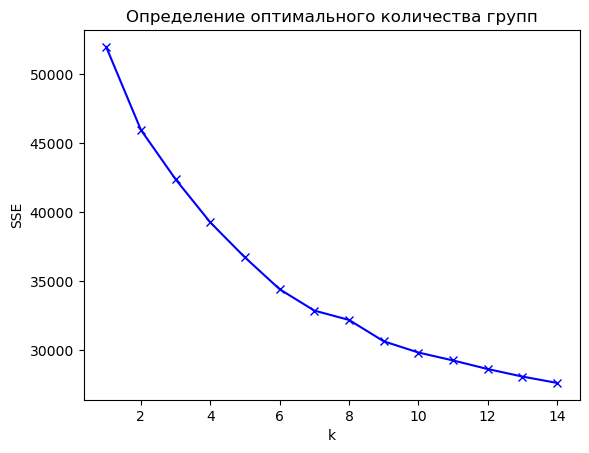

In [ ]:

# подберем оптимальное значение групп по внутрикластерной суме квадратов расстояний
Sum_of_squared_distances =[]
K = range(1,15)
for k in K:
    km =KMeans(random_state=0,n_clusters = k,init = 'random',n_init='auto')
    km =km.fit(X_sc)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('Определение оптимального количества групп')
plt.show()

* **При анализе графика изменения суммы квадратов трудно сделать однозначный вывод о необходимом количестве кластеров, что может говорить об относительной гомогенности данных в нашей выборке**

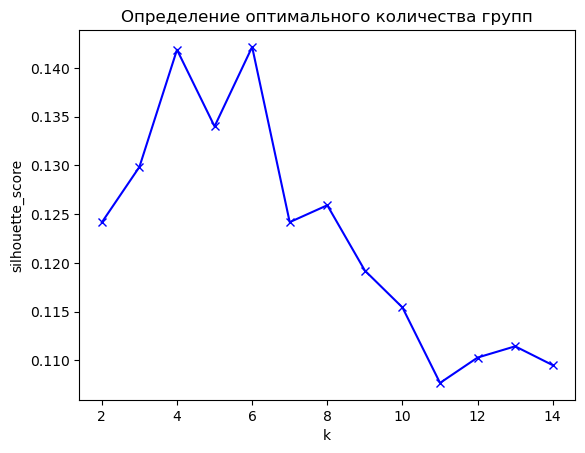

In [ ]:
# подберем оптимальное значение количества кластеров методом силуэта
from sklearn.metrics import silhouette_score
silhouettes =[]
K = range(2,15)
for k in K:
    km = KMeans(random_state=0,n_clusters = k,init = 'random',n_init='auto')
    labels = km.fit_predict(X_sc)
    silhouettes.append(silhouette_score(X_sc, labels, metric='euclidean'))

plt.plot(K, silhouettes, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.title('Определение оптимального количества групп')
plt.show()

* **После анализа графика изменения пораметра siluette_score можно предположить о наличии 6 оптимальных кластеров в наших данных. Однако показатель довольно низкий, что говорит о высоком уровне пересечения точек кластеров.**

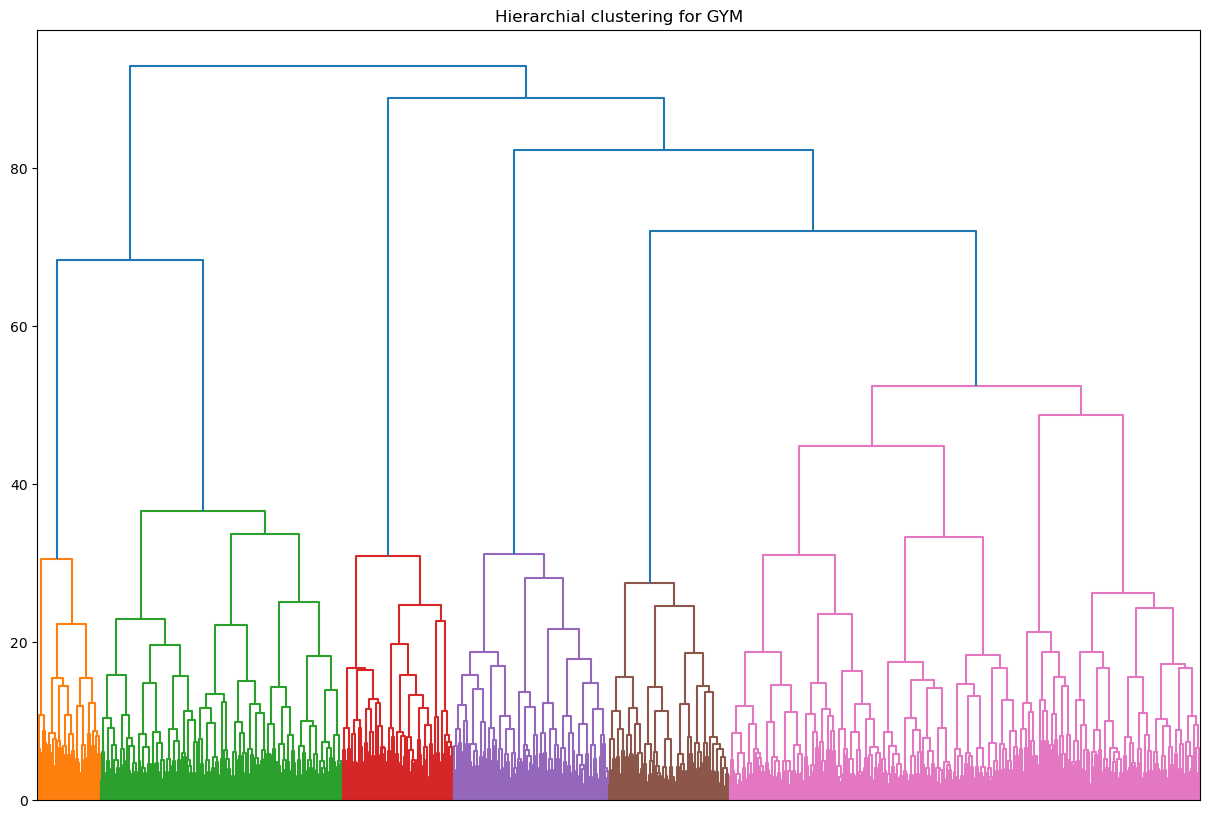

In [ ]:
# проведем иерархическую кластеризацию и отрисуем дендограмму
linked = linkage(X_sc, method = 'ward')
plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for GYM')
plt.xticks([])
plt.show()

* **На динамограмме подтвердились наши предположения об оптимальных 6 кластерах в наших данных**

In [ ]:
# в нашем случае 6 групп, обучим модель
kmeans = KMeans(n_clusters=6,random_state=0,init = 'random',n_init='auto').fit(X_sc)

In [ ]:
# сформируем ряд цвета групп для отображения на карте кластеров
row_colors =  pd.DataFrame( kmeans.labels_ )
row_colors['kmeans_group'] = kmeans.labels_

lut1 = dict(zip(set(kmeans.labels_), ['#ED2323','#000000','#155000','#FFFF00','#0000FF','#FF00FF']))
row_colors = row_colors['kmeans_group'].map(lut1)
row_colors.index = df.index
row_colors.head()

0    #155000
1    #000000
2    #000000
3    #FFFF00
4    #FFFF00
Name: kmeans_group, dtype: object

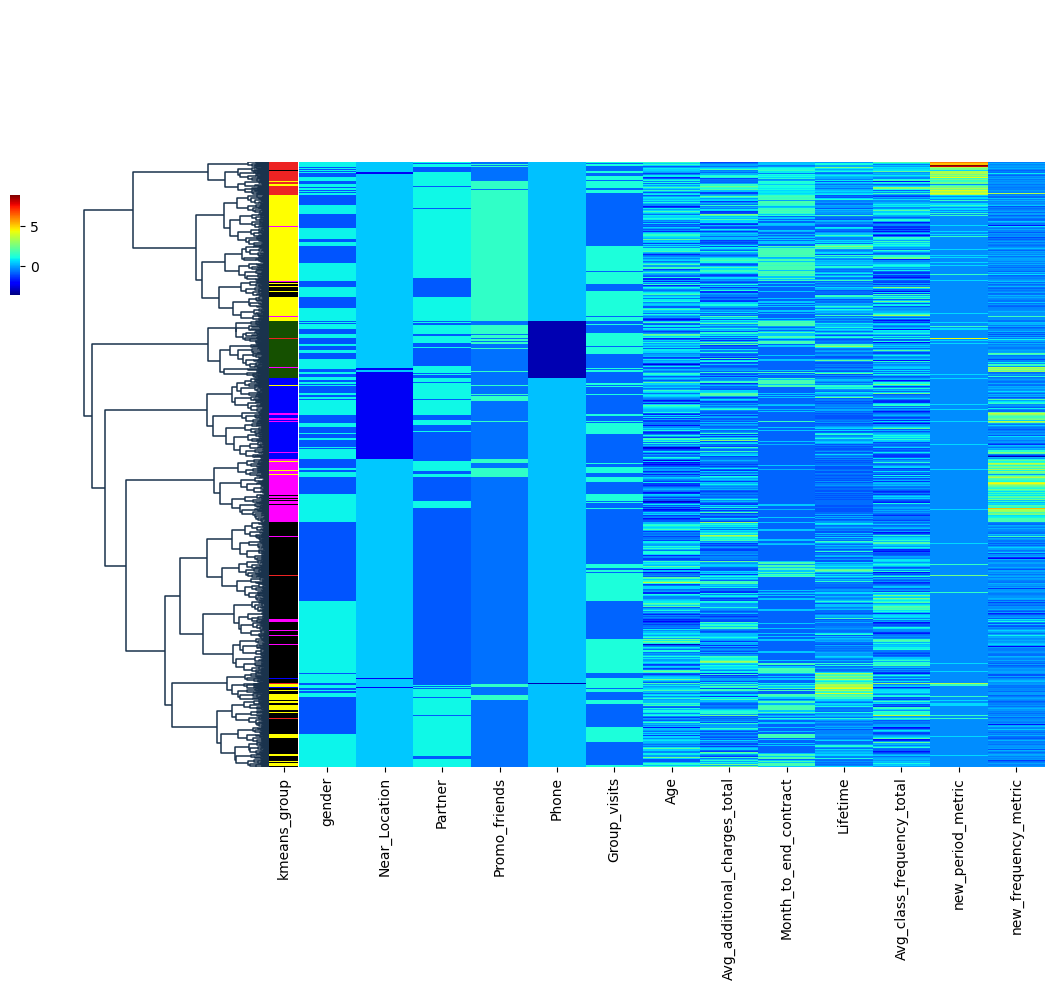

In [ ]:
# построим график для изучения состава кластеров и демонстрации перекрытия групп
h = sns.clustermap(df.drop("Churn", axis =1),annot=False,cbar_pos=(-0.05, .7, .01, .1), yticklabels=False, xticklabels=True,figsize=(10,10),tree_kws=dict(linewidths=1.1, colors=(0.1, 0.2, 0.3)),lw=0.0,
                   row_colors= row_colors,col_cluster=False,cmap="jet",method='ward', z_score = 1)

plt.show()

* **На графике можно проследить предварительные итоги кластеризации: можно заметить смешивание некоторых групп, размер групп не пропорционален, некоторые группы имеют явную концентрацию пользователей с определенными значениями некоторых предикторов**

## Анализ показателей пользователей в группах кластерного анализа

In [ ]:
# добавим поле с результатами к данным
df['kmeans_group'] = kmeans.labels_

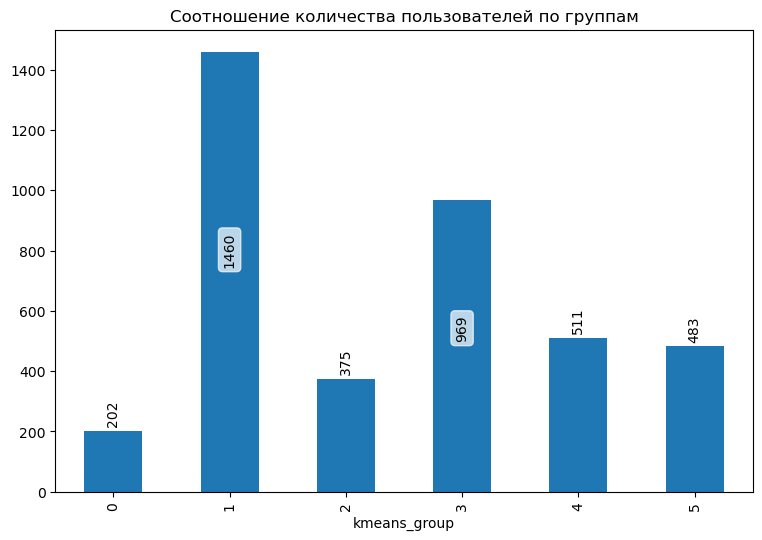

In [ ]:
# посмотрим на соотношение количества пользователей по группам
plt.figure(figsize=(9,6))
ax = df.groupby(by='kmeans_group').count()['gender'].plot(kind = 'bar')
plt.title('Cоотношение количества пользователей по группам')
add_value_labels(ax,'bar',3,"{:.0f}")
plt.show()

In [ ]:
# посмотрим на средние значениия
df.groupby(by='kmeans_group').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Churn,new_period_metric,new_frequency_metric
kmeans_group,,,,,,,,,,,,,,
0,0.509901,0.940594,0.737624,0.386139,0.980198,0.569307,29.935644,159.635604,6.990099,5.168317,2.206887,0.034653,4.207921,0.011916
1,0.504795,1.000000,0.208219,0.055479,1.000000,0.432877,29.695890,154.842103,3.184247,4.106164,1.942436,0.154110,0.089726,-0.009432
2,0.528000,0.864000,0.472000,0.309333,0.000000,0.418667,29.368000,145.067942,4.498667,3.981333,1.841228,0.256000,0.258667,0.109132
3,0.501548,0.994840,0.934985,0.847265,1.000000,0.503612,29.713106,156.741457,7.566563,4.423117,1.966729,0.068111,0.296182,0.005393
4,0.497065,0.000000,0.481409,0.078278,1.000000,0.238748,28.927593,140.088971,2.864971,3.144814,1.768343,0.363992,0.101761,0.100364
5,0.544513,0.917184,0.341615,0.202899,0.985507,0.279503,26.391304,106.812908,1.546584,0.981366,1.520676,0.995859,0.035197,0.749066


* **По средним показателям хорошо заметно, что во всех кластерах примерно одинаковая доля пользователей с наличием телефона и половой принадлежностью, значит эти предикторы не были определяющими при формировании ни одной из групп. Также можно заметить две группы с противоположными крайностями в значениях некоторых предикторов таких как возраст, период жизни, новые метрики и другие, эти две группы явно характиризуют пользователей как склонных к оттоку и нет.**

* ****

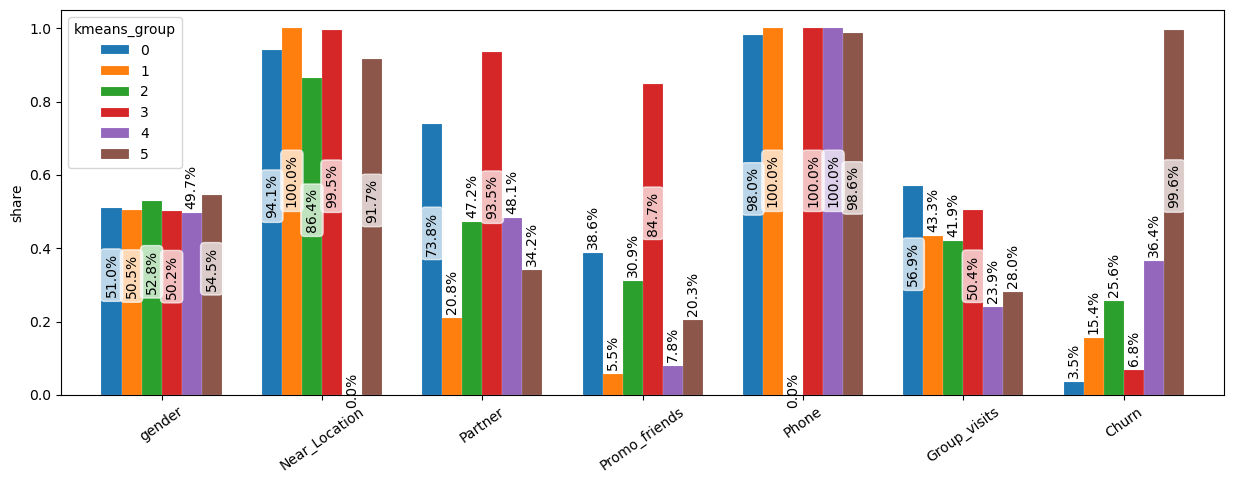

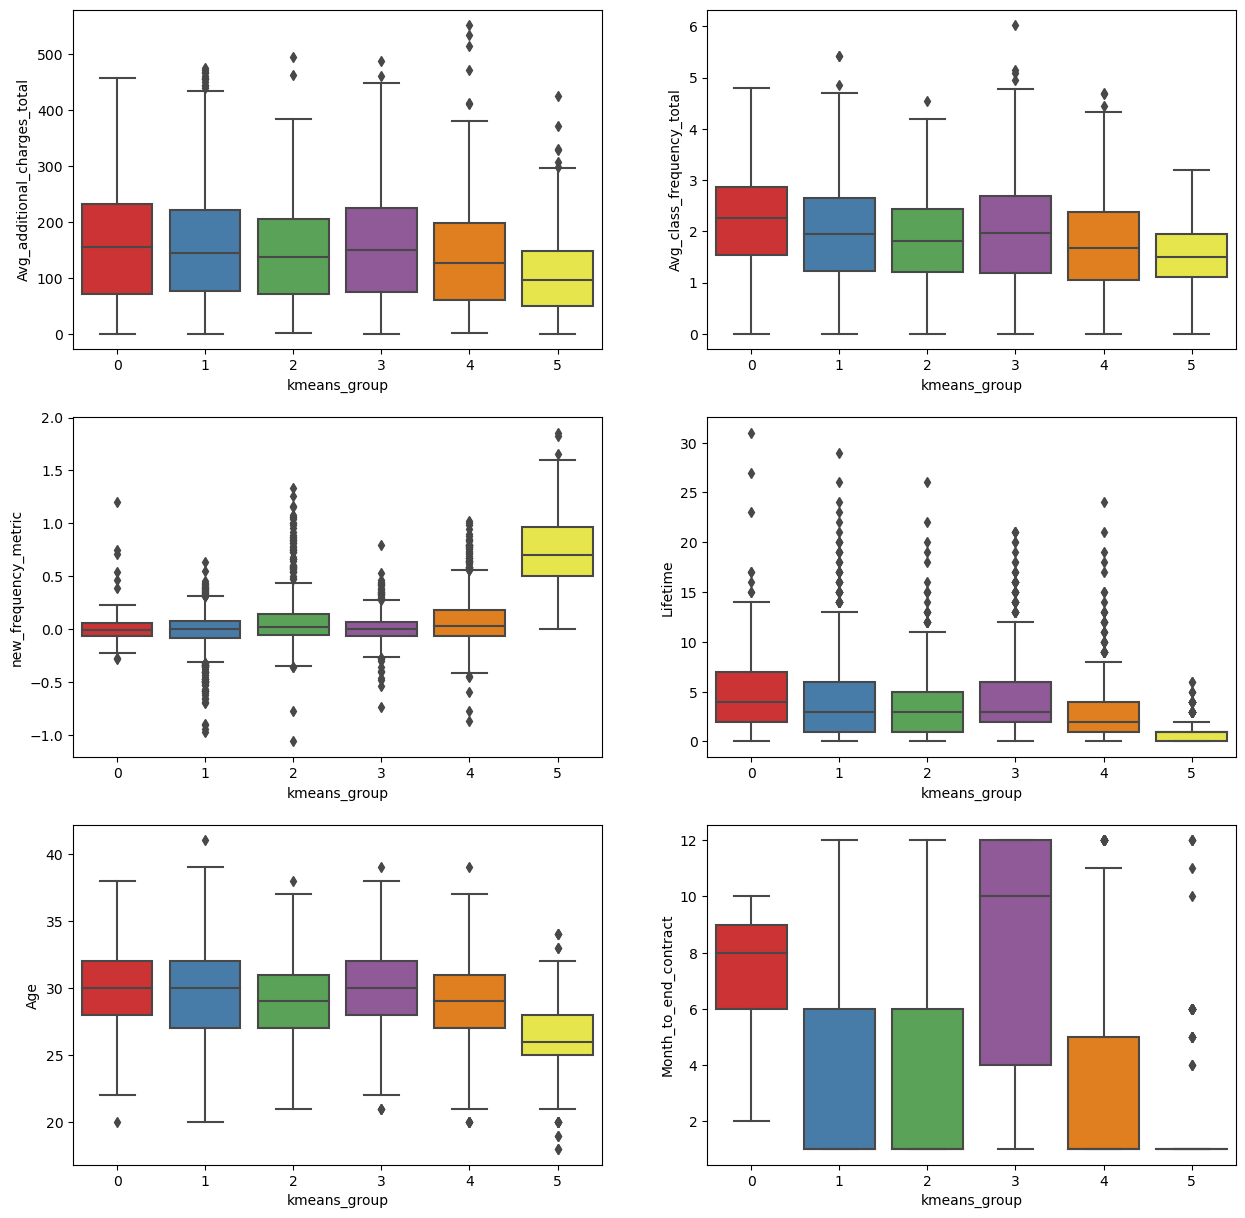

In [ ]:
# Построим графики для более глубокого анализа показателей пользователей в группах кластерного анализа
# Plotting share of nominative predictors
ax = df.groupby(by='kmeans_group')[['gender','Near_Location',   'Partner',  'Promo_friends',    'Phone',    'Group_visits','Churn']].mean().T.plot(kind='bar',figsize=(15,5),width=0.75, edgecolor="white", linewidth=0.1)
add_value_labels(ax,'bar',3,"{:.1%}")
plt.xticks(rotation=(35))
plt.ylabel('share')
plt.show()

plt.figure(figsize=(15, 15))

# Plotting boxplot of float predictors
ax1 = plt.subplot(3, 2, 6)
sns.boxplot(data=df, y="Month_to_end_contract", x="kmeans_group",  palette='Set1',  ax= ax1)
ax4 = plt.subplot(3, 2, 1)
sns.boxplot(data=df, y="Avg_additional_charges_total", x="kmeans_group",  palette='Set1',  ax= ax4)
ax5 = plt.subplot(3, 2, 2)
sns.boxplot(data=df, y="Avg_class_frequency_total", x="kmeans_group",  palette='Set1', ax= ax5)
ax6 = plt.subplot(3, 2, 3)
sns.boxplot(data=df, y="new_frequency_metric", x="kmeans_group",  palette='Set1', ax= ax6)


# Plotting boxplot of discrete predictors
ax7 = plt.subplot(3, 2, 4)
sns.boxplot(data=df, y="Lifetime", x="kmeans_group",  palette='Set1', ax= ax7)
ax8 = plt.subplot(3, 2, 5)
sns.boxplot(data=df, y="Age", x="kmeans_group",  palette='Set1', ax= ax8)


plt.show()

* **После анализа графиков можно выделить две группы характеризующие типичных пользователей которые склонны к оттоку и нет это 5 и 0 соответственно, так склонны к оттоку пользователи с низкими показателями времени жизни,  меньше всех тратящиеся на доп услуги, у которых осталось меньше месяца контрактного времени,  моложе общей массы посетителей и имеют средний возраст около 26 лет. Еще они имеют  низкую общую среднюю частоту посещений в неделю и высокий уровень разности между общей средней частотой посещений и средней частотой посещений за последний месяц, что говорит о том, что у этой группы угасает интерес в посещении заведения параллельно с частотой их визитов, что в итоге ведет к практически стопроцентному оттоку. Напротив мы видим группу - самых надежных посетителей: они имеют высокую продолжительность 'жизни', средний возраст порядка 30 лет, достаточно много тратятся на доп услуги, имеют высокий остаток времени контракта, так же можно отметить самую высокую долю клиентов посещавших групповые занятия в этом кластере, около нулевое значение разности среднего общего количества посещений в неделю и среднего за последний месяц может говорить о стабильности их поведения и отсутствии угасания интереса к посещению зала, отток тут порядка 3,5 процента. Также стоит отметить 4 кластер где несмотря на наличие стабильных посещений, продолжительного периода "жизни" и существенного остатка контрактного периода наблюдается довольно высокая доля оттока - порядка 36%, возможной причинной этому могло послужить то что все пользователя в этом кластере проживают и работают в удалении от зала, это также может сказаться на самом низком показатели групповых занятий тут. В 3 кластере довольно низкий уровень оттока порядка 7 процентов в совокупности с самым высоким остатком по времени контракта и самыми высокими долями сотрудников компаний партнеров и участников различных акций, низкий отток можно объяснить в отсутствие необходимости финансовых затрат на продление абонемента. Во втором кластере видно отсутствие телефонов и отток в 25%, что можно связать с отсутствием влияния смс информирования и рекламных рассылок на этих клиентов. В оставшемся кластере существенных закономерностей не выявлено это среднестатистические пользователи с оттоком в 15% к которому можно стремиться**


# Вывод по итогам кластеризации:
- Кластер 5 представляет пользователей, склонных к оттоку.

- Кластер 0 представляет самых надежных посетителей.

- Кластер 4 характеризуется существенной долей оттока (порядка 36%), несмотря на стабильные посещения, длительный срок жизни и остаток контракта. Это может быть связано с удаленностью пользователей от клуба и низким уровнем участия в групповых занятиях.

- Кластер 3 отличается низким уровнем оттока (около 7%) в сочетании с длительным контрактным сроком и высокой долей сотрудников партнерских компаний и участников акций.

- В кластере 2 отмечается отсутствие указания номеров телефонов и высокий уровень оттока (25%), что может быть связано с отсутствием влияния смс-информирования и рекламных рассылок на этих клиентов.

- В оставшемся кластере существенных закономерностей не выявлено. Он представляет среднестатистических пользователей с уровнем оттока в 15%, к которому можно стремиться. Получается он такой, промежуточный

# Общий вывод и рекомендации:
* **Склонны к оттоку пользователи с низкими показателями времени жизни, которые меньше всех тратятся на доп услуги, у которых осталось меньше месяца контрактного времени, они моложе общей массы посетителей и имеют средний возраст около 26 лет. Еще они имеют низкую общую среднюю частоту посещений в неделю и высокий уровень разности между общей средней частотой посещений и средней частотой посещений за последний месяц, что говорит о том, что у этой группы угасает интерес в посещении заведения параллельно с частотой их визитов, что в итоге ведет к практически стопроцентному их оттоку**
  * **Эта категория явно заскучала и теряет интерес к посещению, необходимо поднять мотивацию, предложив скидку на групповые занятия либо подарочный сертификат на дополнительные услуги**
* **Самые надежные посетители имеют высокую продолжительность 'жизни', средний возраст порядка 30 лет, достаточно много тратятся на доп услуги, имеют высокий остаток времени контракта, так же можно отметить самую высокую долю клиентов посещавших групповые занятия в этом кластере, около нулевое значение разности среднего общего количества посещений в неделю и среднего за последний месяц может говорить о стабильности их поведения и отсутствии угасания интереса к посещению зала**
     * **Лояльность данной категории необходимо использовать для расширения аудитории и рекламы своего бизнеса посредствам таких акций как 'приведи друга', либо проводить розыгрыши ценных призов за посты в своих социальных сетях с рекламой услуг**
* **Немаловажную роль во влиянии на уровень оттока имеет близость зала, поэтому необходимо очень грамотно выбирать место расположение заведения, с потенциально самым высоким уровнем доступности**
* **Отсутствие телефона пользователя повышает шансы его потерять, необходимо по возможности получать такую информацию и коммуницировать по средствам смс рассылок**

<div class="alert alert-block alert-success">
<b>Успех👍:</b>
    
Рекомендации вышли продуктивными и основанными на твоей работе:
    
- Скидки хороший мотиватор для похода в клуб
- Рекламу действительно стоит улучшать - молодец)
- Местоположение зала действительно стоит лучше оценивать
- Ну и телефоны да, стоит делать рассылки итп
</div>

<div style="border:solid Chocolate 2px; padding: 40px">

<h2><b>Общий вывод по проекту</b></h2>

Ты очень постарался, спасибо тебе за такую работу!)

В ходе проекта были выполнены все этапы проекта, главная цель достигнута. Ты реализовал все крайне точно, подробно и просто, молодец). Мне очень понравился этап с графиками для кластеров, честно. Конечно присутствует ряд моментов, которые необходимо рассмотреть, но ничего страшного, для это я здесь). Давай пройдемся по всему что ты сделал, чтобы понять что надо сделать для того, чтобы проект был засчитан:

- Есть советы по проекту, если хочешь и есть время - реализуй их. Если нет, то запомни на будущее)

Работа классная, проект принимаю, ты отлично справился). Удачи в следующем проекте)